In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
from matplotlib import rc

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2.0,
    'legend.columnspacing' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# frequency information: histogram, cumulant histogram

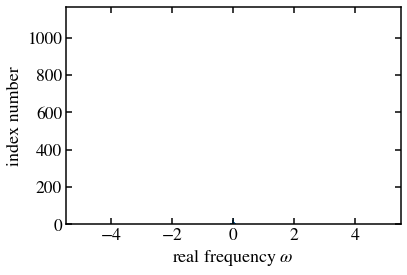

In [2]:
D = 1
out_node = 2
npoint = 2001
N = 10000
directory = '../1_dmftsolver/NRG'
weq = np.linspace(-5, 5, npoint)


w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_41_beta10000/Bethe-{2.25:.3f}.dat', \
                       unpack = True, dtype = 'complex128')

#plt.plot(w.real, np.arange(len(w)))
#plt.xlabel(r'real frequency $\omega$')
#plt.ylabel('cumulant number')
#plt.axhspan(1319-500, 1319+500, alpha=0.5, color='#ffee52')
#plt.annotate(r'$\omega\simeq0$', xy=(0.4, 0.475), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.show()


number, bins, patches = plt.hist(w.real, bins=npoint)
plt.xlabel(r'real frequency $\omega$')
plt.ylabel('index number')
plt.show()

def G(x):
    return np.array([simps(x/(1j*omega[i]-w.real), w) for i in range (N)])
def Geq(x):
    return np.array([simps(x/(1j*omega[i]-weq), weq) for i in range (N)])

def Gmat(x):
    return -np.array([G(xx) for i, xx in enumerate(x)])/np.pi
def Geqmat(x):
    return -np.array([Geq(xx) for i, xx in enumerate(x)])/np.pi

omega = np.pi/10000 * (2*np.arange(N)+1) # w_n
iwnumber = -Geq(number).imag/np.pi

#plt.plot(omega, iwnumber)
#plt.xlabel(r'imag frequency $i\omega_n$')
#plt.ylabel('index number')
#plt.yscale('log')

# Data: NRG, ED

In [3]:
beta = 10000
U_c1_4, U_c2_4 = 2.25, 2.88
    
w_len = len(np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

up_num = 229
dn_num = 242

U = np.array([0.001*i for i in range(600, 5001)])
U1_4 = np.zeros(up_num, dtype = 'float64')
U2_4 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_4[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_4[n] = u
    n += 1
    
x_test_4_up = np.zeros((len(U1_4), 2638*2), dtype = 'float64')
x_test_4_dn = np.zeros((len(U2_4), 2638*2), dtype = 'float64')
# test data
for i, u in enumerate(U1_4):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4_up[i, :2638], x_test_4_up[i, 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
for i, u in enumerate(U2_4):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4_dn[i, :2638], x_test_4_dn[i, 2638:] = ((D/2)**2*G_r), ((D/2)**2*G_i)
x_test_4_up = -torch.FloatTensor(x_test_4_up)
x_test_4_dn = -torch.FloatTensor(x_test_4_dn)

# Metal = 1, Insulator = 0
y_temp1 = np.array(U1_4 < U_c2_4)
y_temp2 = np.array(U2_4 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_4 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_4 = torch.FloatTensor(y_test_4)
UU_4 = np.concatenate((U1_4, U2_4))


In [ ]:
'''def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (N)])

beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93

U = np.array([0.01*i for i in range(50, 501)])
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed_up = np.zeros((len(U1_ed), 20000), dtype = 'float64')
x_test_ed_dn = np.zeros((len(U2_ed), 20000), dtype = 'float64')
for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    mid = EDbath(e,V)
    x_test_ed_up[i][:10000], x_test_ed_up[i][10000:] = mid.real, mid.imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    mid = EDbath(e,V)
    x_test_ed_dn[i][:10000], x_test_ed_dn[i][10000:] = mid.real, mid.imag
x_test_ed_up = torch.FloatTensor(-x_test_ed_up)
x_test_ed_dn = torch.FloatTensor(-x_test_ed_dn)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)
UU_ed = np.concatenate((U1_ed, U2_ed))'''

# To bring frozen Neural Network Model

In [5]:
'''class LRNet(nn.Module):
    def __init__(self, activate = None):
        super(LRNet, self).__init__()
        self.W1 = nn.Linear(20000, out_node)#, bias=False)
        self.b1 = nn.Linear(out_node, 1)#, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        
        #W1_ = np.loadtxt('frozen_mat/LR_W1_iw.txt', dtype='float64')
        #b1_ = np.loadtxt('frozen_mat/LR_b1.txt', dtype='float64')
        #self.W1.weight.data = torch.FloatTensor(W1_)
        #self.b1.weight.data = torch.FloatTensor(b1_)

    def forward(self, x):
        x = self.W1(x)+self.b1.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)
    
    
class NN10Net(nn.Module):
    def __init__(self, activate = None):
        super(NN10Net, self).__init__()
        self.W1 = nn.Linear(20000, 10)#, bias=False)
        self.b1 = nn.Linear(10, 1, bias=False)
        self.W2 = nn.Linear(10, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        
        #W1_ = np.loadtxt('frozen_mat/NN10_W1_iw.txt', dtype='float64')
        #b1_ = np.loadtxt('frozen_mat/NN10_b1.txt', dtype='float64')
        #W2_ = np.loadtxt('frozen_mat/NN10_W2.txt', dtype='float64')
        #b2_ = np.loadtxt('frozen_mat/NN10_b2.txt', dtype='float64')
        #self.W1.weight.data = torch.FloatTensor(W1_)
        #self.W2.weight.data = torch.FloatTensor(W2_)
        #self.b1.weight.data = torch.FloatTensor(b1_)
        #self.b2.weight.data = torch.FloatTensor(b2_)
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

class NN100Net(nn.Module):
    def __init__(self, activate = None):
        super(NN100Net, self).__init__()
        self.W1 = nn.Linear(20000, 100)#, bias=False)
        self.b1 = nn.Linear(100, 1, bias=False)
        self.W2 = nn.Linear(100, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        
        #W1_ = np.loadtxt('frozen_mat/NN100_W1_iw.txt', dtype='float64')
        #b1_ = np.loadtxt('frozen_mat/NN100_b1.txt', dtype='float64')
        #W2_ = np.loadtxt('frozen_mat/NN100_W2.txt', dtype='float64')
        #b2_ = np.loadtxt('frozen_mat/NN100_b2.txt', dtype='float64')
        #self.W1.weight.data = torch.FloatTensor(W1_)
        #self.W2.weight.data = torch.FloatTensor(W2_)
        #self.b1.weight.data = torch.FloatTensor(b1_)
        #self.b2.weight.data = torch.FloatTensor(b2_)
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)'''

'''matdir='./frozen_mat'
W1_LR = np.loadtxt(f'{matdir}/LR_W1.txt', dtype='float64')
W1_NN10 = np.loadtxt(f'{matdir}/NN10_W1.txt', dtype='float64')
W1_NN100 = np.loadtxt(f'{matdir}/NN100_W1.txt', dtype='float64')
W2_NN10 = np.loadtxt(f'{matdir}/NN10_W2.txt', dtype='float64')
W2_NN100 = np.loadtxt(f'{matdir}/NN100_W2.txt', dtype='float64')

reW1_LR = np.loadtxt(f'{matdir}/LR_W1_re.txt', dtype='float64')
reW1_NN10 = np.loadtxt(f'{matdir}/NN10_W1_re.txt', dtype='float64')
reW1_NN100 = np.loadtxt(f'{matdir}/NN100_W1_re.txt', dtype='float64')

iwW1_LR = np.loadtxt(f'{matdir}/LR_W1_iw.txt', dtype='float64')
iwW1_NN10 = np.loadtxt(f'{matdir}/NN10_W1_iw.txt', dtype='float64')
iwW1_NN100 = np.loadtxt(f'{matdir}/NN100_W1_iw.txt', dtype='float64')'''

In [4]:
size = 2638*2
class LRNet(nn.Module):
    def __init__(self, activate = None):
        super(LRNet, self).__init__()
        self.W1 = nn.Linear(size, out_node)#, bias=False)
        self.b1 = nn.Linear(out_node, 1)#, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        #self.W1.weight.data.fill_(0)
        nn.init.uniform_(self.W1.weight.data, -0.005, 0.005)
        self.b1.weight.data.fill_(0)
        
    def forward(self, x):
        x = self.W1(x)+self.b1.weight.data
        return self.sig(x)
    
class NN10Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(NN10Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        nn.init.uniform_(self.W1.weight, -0.001, 0.001)
        nn.init.xavier_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

class NN100Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(NN100Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        nn.init.uniform_(self.W1.weight, -0.001, 0.001)
        nn.init.xavier_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

In [5]:
func = nn.Sigmoid
LRmodel = LRNet(activate = func)
NN10model = NN10Net(activate = func, node=10)
NN100model = NN100Net(activate = func, node=100)


LRmodel.load_state_dict(torch.load('./frozen_mat/LRmodel.pth'))
NN10model.load_state_dict(torch.load('./frozen_mat/NN10model.pth'))
NN100model.load_state_dict(torch.load('./frozen_mat/NN100model.pth'))

<All keys matched successfully>

In [6]:
def Wimag(x, n, h, zero): # h = bandwidth
    #a = 1/(sigma)*np.exp(-(x - np.arange(2638))**2/(2*sigma**2)) * np.array(model.W1.weight.data[n, :])
    a = np.exp(-(np.log(np.abs(w.real[zero:]/w.real[x])))**2/(2*h**2)) 
    a = a * np.array(LRmodel.W1.weight.data[n, 2638+zero:])
    a = a/(h * (2*np.pi)**0.5)
    a = a/(np.abs(w.real[zero:])+5e-5)
    return np.sum(a)

def Wreal(x, n, h, zero): # h = bandwidth
    #a = 1/(sigma)*np.exp(-(x - np.arange(2638))**2/(2*sigma**2)) * np.array(model.W1.weight.data[n, :])
    a = np.exp(-(np.log(np.abs(w.real[zero:]/w.real[x])))**2/(2*h**2)) 
    a = a * np.array(LRmodel.W1.weight.data[n, zero:2638])
    a = a/(h * (2*np.pi)**0.5)
    a = a/(np.abs(w.real[zero:])+5e-5)
    return np.sum(a)

zero=0
#W_w_imag_s = Weight[0, npoint:]*number
#W_w_real_s = Weight[0, :npoint]*number
W_w_imag_s = np.array(LRmodel.W1.weight.data[0, 2638:]/np.abs(w.real))
W_w_real_s = np.array(LRmodel.W1.weight.data[0, :2638]/np.abs(w.real))

#W_w_imag_s = np.array([Wimag(i, 0, 0.05, zero) for i in range (zero, 2638)])
#W_w_real_s = np.array([Wreal(i, 0, 0.05, zero) for i in range (zero, 2638)])
W_w_imag_L = np.array([Wimag(i, 0, 0.2, zero) for i in range (zero, 2638)])
W_w_real_L = np.array([Wreal(i, 0, 0.2, zero) for i in range (zero, 2638)])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


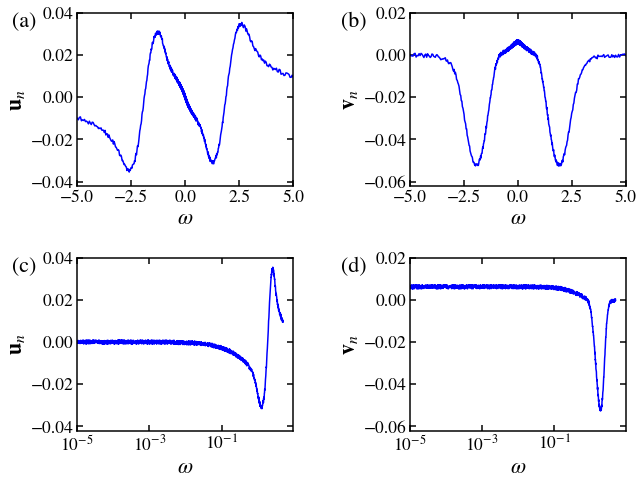

In [10]:
a = 0.05

ax0 = plt.axes([0.20+a, 1.45, 0.5, 0.6])
ax1 = plt.axes([0.97+a, 1.45, 0.5, 0.6])
ax2 = plt.axes([0.20+a, 0.6, 0.5, 0.6])
ax3 = plt.axes([0.97+a, 0.6, 0.5, 0.6])
#ax00 = plt.axes([0.54+a, 1.85, 0.15, 0.18])
#ax11 = plt.axes([1.31+a, 1.85, 0.15, 0.18])

ax0.plot(w.real, W_w_real_s*np.abs(w.real), c='b')
ax0.set_ylim(-4.2e-2, 4e-2)
ax0.set_yticks([-0.04, -0.02, 0.00, 0.02, 0.04])
ax0.set_xlim(-5, 5)
ax0.set_ylabel(r'$\mathbf{u}_n$', fontsize=22)
ax0.set_xlabel(r'$\omega$', fontsize=22)
#ax0.set_yticks([0, 1e4, 2e4])
#ax0.set_yticklabels(['0', r'$1\cdot10^4$', r'$2\cdot 10^4$'])

ax1.plot(w.real, W_w_imag_s*np.abs(w.real), c='b')
ax1.set_ylim(-6.2e-2, 2e-2)
ax1.set_xlim(-5, 5)
ax1.set_yticks([-0.06, -0.04, -0.02, 0.00, 0.02])
ax1.set_ylabel(r'$\mathbf{v}_n$', fontsize=22)
ax1.set_xlabel(r'$\omega$', fontsize=22)
#ax1.set_yticks([0, 1e4, 2e4])
#ax1.set_yticklabels(['0', r'$1\cdot10^4$', r'$2\cdot 10^4$'])

ax2.plot(w.real, W_w_real_s*np.abs(w.real), c='b')
#ax2.plot(w.real, -2e-2*w.real, '--', c='k', label=r'$-\alpha\omega$')
ax2.set_xscale('log')
ax2.set_xlim(1e-5)
ax2.set_yticks([-0.04, -0.02, 0.00, 0.02, 0.04])
ax2.set_ylim(-4.2e-2, 4e-2)
ax2.set_ylabel(r'$\mathbf{u}_n$', fontsize=22)
ax2.set_xlabel(r'$\omega$', fontsize=22)
ax2.legend(loc='lower left')

ax3.plot(w.real, W_w_imag_s*np.abs(w.real), c='b')
#ax3.plot(w.real, 6.3e-3-8.7e-3*np.abs(w.real), '--', c='k', label=r'$\beta-\gamma|\omega|$')
ax3.set_xscale('log')
ax3.set_xlim(1e-5)
ax3.set_ylim(-6.2e-2, 2e-2)
ax3.set_yticks([-0.06, -0.04, -0.02, 0.00, 0.02])
ax3.set_ylabel(r'$\mathbf{v}_n$', fontsize=22)
ax3.set_xlabel(r'$\omega$', fontsize=22)
ax3.legend(loc='lower left')

#ax00.plot(w.real, W_w_real_s, c='b')
#ax00.plot(w.real, 0.0077/w.real, '--', c='k')
#ax00.set_xlim(-1.5, 1.5)
#ax00.set_ylim(np.min(W_w_real_s)-np.max(W_w_imag_s)*0.1, np.max(W_w_imag_s)*1.1)
#ax00.set_xticks([0, 1e-3])
#ax00.set_xticklabels(['0', '1e-3'])
#ax00.set_yticks([0,100])
#ax00.set_yticklabels(['0','1e2'])
#ax00.tick_params(labelsize=14)
#ax00.tick_params(axis=u'both', which=u'both', length=3)

#ax11.plot(w.real, W_w_imag_s, c='b')
#ax11.plot(w.real, 0.0077/w.real, '--', c='k')
#ax11.set_xlim(-1.5, 1.5)
#ax11.set_ylim(np.min(W_w_real_s)-np.max(W_w_imag_s)*0.1, np.max(W_w_imag_s)*1.1)
#ax11.set_xticks([0, 1e-3])
#ax11.set_xticklabels(['0', '1e-3'])
#ax11.set_yticks([0,100])
#ax11.set_yticklabels(['0','1e2'])
#ax11.tick_params(labelsize=14)
#ax11.tick_params(axis=u'both', which=u'both', length=3)
plt.gcf().text(0.1, 2.0-0.0, '(a)', fontsize = 22)
plt.gcf().text(0.1, 1.15-0.0, '(c)', fontsize = 22)
plt.gcf().text(0.86, 2.0-0.0, '(b)', fontsize = 22)
plt.gcf().text(0.86, 1.15-0.0, '(d)', fontsize = 22)

plt.savefig('fig4.pdf')

# Figure. Training flow & Test result

In [8]:
print(sns.color_palette("plasma", 20).as_hex())
sns.color_palette("plasma", 20)

['#2a0593', '#3f049c', '#5302a3', '#6600a7', '#7801a8', '#8b0aa5', '#9c179e', '#ab2494', '#b83289', '#c5407e', '#d14e72', '#db5c68', '#e56a5d', '#ed7953', '#f48849', '#f99a3e', '#fdab33', '#febd2a', '#fcd025', '#f7e425']


[(0.16407, 0.020171, 0.577478),
 (0.248032, 0.014439, 0.612868),
 (0.32515, 0.006915, 0.639512),
 (0.399411, 0.000859, 0.656133),
 (0.471457, 0.005678, 0.659897),
 (0.546157, 0.038954, 0.64701),
 (0.610667, 0.090204, 0.619951),
 (0.669845, 0.142992, 0.582154),
 (0.723444, 0.196158, 0.538981),
 (0.771958, 0.249237, 0.494813),
 (0.819651, 0.306812, 0.448306),
 (0.85975, 0.360588, 0.406917),
 (0.896131, 0.415712, 0.366407),
 (0.928329, 0.472975, 0.326067),
 (0.95547, 0.533093, 0.28549),
 (0.977856, 0.602051, 0.241387),
 (0.990681, 0.669558, 0.201642),
 (0.994495, 0.74088, 0.166335),
 (0.987621, 0.815978, 0.144363),
 (0.968443, 0.894564, 0.147014)]

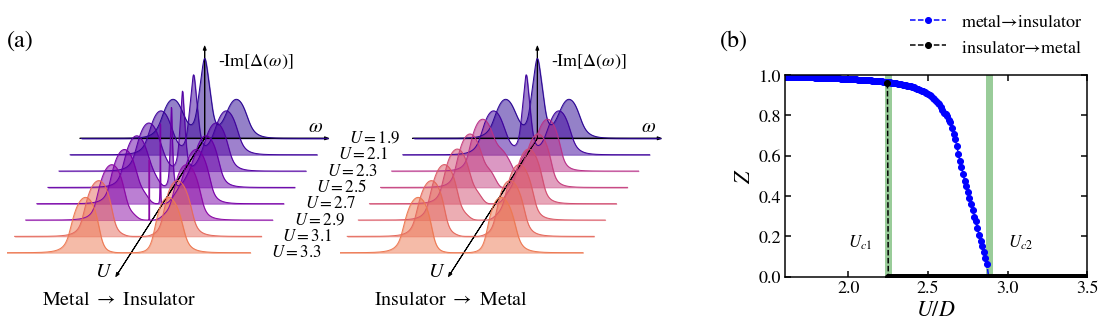

In [21]:
prefix = ['./NRG_metal_insulator/', './NRG_insulator_metal/']
labels = [r'Metal $\rightarrow$ Insulator',
          r'Insulator $\rightarrow$ Metal']
Uarr = [['1.900', '2.100', '2.300', '2.500', '2.700', '2.900', '3.100', '3.300'],
        ['1.900', '2.100', '2.300', '2.500', '2.700', '2.900', '3.100', '3.300']]
Ucs = [2.9, 2.25]
colors = sns.color_palette("plasma", 20).as_hex()

dx, dy = -0.45, -0.13

ax1 = plt.axes((0.15, 2.0, 0.8, 0.8), xticks = [], yticks = [], frameon = False)
ax2 = plt.axes((0.92, 2.0, 0.8, 0.8), xticks = [], yticks = [], frameon = False)
axs = [ax1, ax2]
shrinkA, shrinkB = 0, 0
for k, ax in enumerate(axs):
    def color_of_phase(U):
        Us = np.array(Uarr[k]).astype('float')
        idx = np.abs(Us-U).argmin()
        cond = int(U <= Ucs[k])
        sign = int(2.0*(cond-0.5))
        idx1 = (1-cond)*(len(Uarr[k]))+sign*idx+(1-cond)*6
        return colors[sign*idx1]

    # z axis
    ax.annotate('', \
      xy = (0.5715, 1.0), xytext = (0.5715, 0.6), \
      xycoords = 'axes fraction', textcoords = 'axes fraction', \
      arrowprops = dict(width = 0.05, headwidth = 3, headlength = 4, color='black', \
          shrinkA = shrinkA, shrinkB = shrinkB), \
      size = 'large', zorder = 1)
    ax.text(0.61, 0.92, r'-Im$[\Delta(\omega)]$', fontsize = 18, transform = ax.transAxes)

    # x axis
    ax.annotate('', \
      xy = ((len(Uarr[0])*dx+8)/14, 0.0), xytext = (0.5715, 0.6), \
      xycoords = 'axes fraction', textcoords = 'axes fraction', \
      arrowprops = dict(width = 0.05, headwidth = 3, headlength = 4, color='black', \
          shrinkA = shrinkA, shrinkB = shrinkB), \
      size = 'large', zorder = 1)
    ax.text(-0.06+(len(Uarr[0])*dx+8)/14, 0.0, r'$U$', fontsize = 20, transform = ax.transAxes)

    # y axis
    ax.annotate('', \
      xy = (0.93, 0.6), xytext = (0.21, 0.6), \
      xycoords = 'axes fraction', textcoords = 'axes fraction', \
      arrowprops = dict(width = 0.05, headwidth = 3, headlength = 4, color='black', \
          shrinkA = shrinkA, shrinkB = shrinkB), \
      size = 'large', zorder = 1)
    ax.text(0.87, 0.63, r'$\omega$', fontsize = 20, transform = ax.transAxes)

    for i, U in enumerate(Uarr[k]):
        filename = f'Bethe-{U}.dat'
        w, Aw = np.loadtxt(prefix[k] + filename, unpack = True)
        w = w+i*dx
        Aw = Aw+i*dy
        ax.plot(w, Aw, color = color_of_phase(float(U)), linestyle = '-', linewidth = 1)
        ax.fill_between(w, i*dy, Aw, color = color_of_phase(float(U)), alpha = 0.5)
        if k == 0:
            ax.text(w[-1]+0.85, Aw[-1]-0.03, r'$U=%.1f$'%float(U), fontsize = 17)

    ax.text(0.10, -0.12, labels[k], fontsize = 20, transform = ax.transAxes)
    ax.set_xlim([-8, 6])
    ax.set_ylim([-1.1, 0.735])

plt.gcf().text(0.15,2.8, '(a)', fontsize = 24)
plt.gcf().text(1.8,2.8, '(b)', fontsize = 24)


ax0 = plt.axes((1.95, 2.0, 0.7, 0.7), xticks = [], yticks = [], facecolor = 'None', frameon = True)
ax0.axvline(U_c1_4, c = '#99CC99', lw = '7')
ax0.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax0.plot(U1_4, Z1, 'bo--', label=r'metal$\to$insulator')
ax0.plot(U2_4, Z2, 'ko--', label=r'insulator$\to$metal')
ax0.annotate(r'$U_{c1}$', xy=(0.25, 0.15), xycoords = 'axes fraction', fontsize=17, ha='center')
ax0.annotate(r'$U_{c2}$', xy=(0.78, 0.15), xycoords = 'axes fraction', fontsize=17, ha='center')
ax0.set_xlabel(r'$U/D$', fontsize=22)
ax0.set_ylabel(r'$Z$', fontsize=22)
ax0.set_xlim(1.6, 3.5)
ax0.set_ylim(0, 1)

ax0.set_xticks([2.0, 2.5, 3.0, 3.5])
ax0.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax0.tick_params(labelsize=18)

ax0.legend(bbox_to_anchor=(0.7, 1.2), loc='center', fontsize=18)

plt.savefig('fig1.png', bbox_inches='tight')

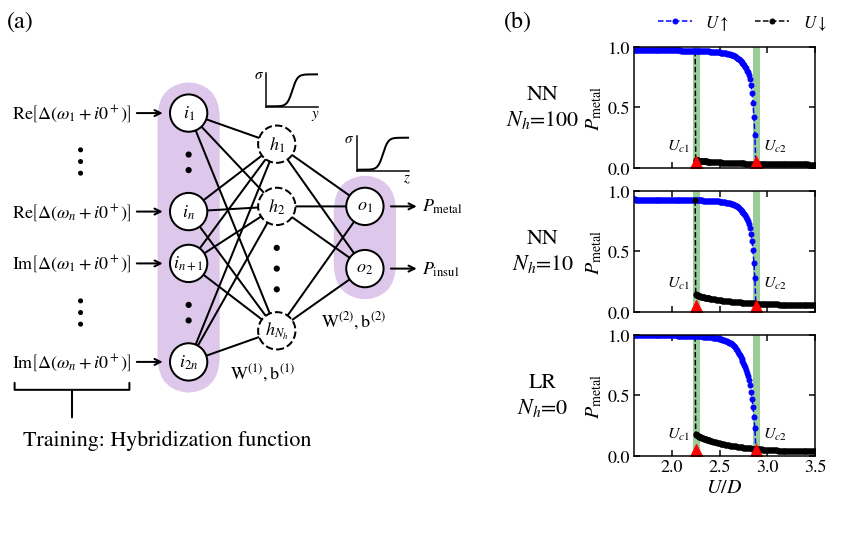

In [9]:
xsize, ysize=1.2, 1.8
ax0 = plt.axes((0.12, 0, xsize, ysize), xticks = [], yticks = [], facecolor = 'None', frameon = False)
ax5 = plt.axes((0.72, 1.46, 0.12, 0.12), xticks = [], yticks = [], facecolor = 'None', frameon = True)
ax6 = plt.axes((0.93, 1.24, 0.12, 0.12), xticks = [], yticks = [], facecolor = 'None', frameon = True)

plt.gcf().text(0.12,ysize-0.06, '(a)', fontsize = 24)
plt.gcf().text(1.27,ysize-0.06, '(b)', fontsize = 24)

#########################################33


###############################################

inode_x, inode_y = 0.35, 0.8
hnode_x, hnode_y = 0.52, inode_y-0.12/2
onode_x, onode_y = 0.69, inode_y-0.12*2+0.12/2

r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.22, edgecolor = 'none', facecolor = '#6600a7')
r2 = mpatches.FancyBboxPatch((onode_x-0.04,onode_y-0.12-0.04), 0.08,0.2, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.22, edgecolor = 'none', facecolor = '#6600a7')
ax0.add_patch(r1)
ax0.add_patch(r2)

# input layer
for i in range(1):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
    ax0.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.08-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    o = mpatches.Circle((inode_x, inode_y-0.37-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.19-0.10*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.annotate('', xy=(inode_x-0.1, inode_y-0.19-0.10*i), xytext=(inode_x-0.05, inode_y-0.19-0.10*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax0.text(inode_x, inode_y-0.19-0.10*0, r'$i_n$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
ax0.text(inode_x, inode_y-0.19-0.10*1, r'$i_{n+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.34, inode_y, r'Re$\left[\Delta(\omega_1+i0^+)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.34, inode_y-0.19, r'Re$\left[\Delta(\omega_n+i0^+)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.34, inode_y-0.19-0.10*1, r'Im$\left[\Delta(\omega_1+i0^+)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.34, inode_y-0.12*4, r'Im$\left[\Delta(\omega_n+i0^+)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)

o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
ax0.add_patch(o)
ax0.text(inode_x, inode_y-0.12*4, r'$i_{2n}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)

ax0.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
# hidden layer
for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
    ax0.add_patch(o)
    ax0.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
ax0.add_patch(o)
ax0.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
# output layer
for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
    ax0.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax0.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax0.transAxes)
ax0.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax0.transAxes)
# lines
iy_coord = [inode_y]
iy_coord.append(inode_y-0.19)
iy_coord.append(inode_y-0.19-0.10*1)
iy_coord.append(inode_y-0.12*4)
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax0.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax0.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
        
ax0.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax0.transAxes)

ax0.text(0.03, inode_y-0.12*4-0.15, 'Training: Hybridization function', fontsize = 22, \
             va='center', transform = ax0.transAxes)
ax0.annotate('', xy=(inode_x-0.225, inode_y-0.12*4-0.05), xytext=(inode_x-0.225, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=4.1, lengthB=.5',lw=2), transform = ax0.transAxes)

ax0.text(inode_x-0.207, inode_y-0.19/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax0.transAxes)
ax0.text(inode_x-0.207, inode_y-0.77/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax0.transAxes)

ax5.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax5.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax5.set_xlabel(r'$y$', fontsize=15)
ax5.xaxis.set_label_coords(0.95, -0.03)
ax5.yaxis.set_label_coords(-0.15, 0.75)
ax5.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax5.set_ylim(-0.03,1.05)
ax5.set_xlim(-5,5)
ax6.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax6.set_xlabel(r'$z$', fontsize=15)
ax6.xaxis.set_label_coords(0.95, -0.03)
ax6.yaxis.set_label_coords(-0.15, 0.75)
ax6.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax6.set_ylim(-0.03,1.05)
ax6.set_xlim(-5,5)


##################################################################
a, b = 1.25, 0
ax30 = plt.axes((1.57, 0+a, 0.42, 0.42), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax31 = plt.axes((1.57, -0.5+a, 0.42, 0.42), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax32 = plt.axes((1.57, -1.0+a, 0.42, 0.42), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)

ax30.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax30.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax30.plot(U2_4, NN100model.forward(x_test_4_dn).data[:,0], 'ko--', ms=5, label = r'$U \downarrow$')
ax30.plot(U1_4, NN100model.forward(x_test_4_up).data[:,0], 'bo--', ms=5, label = r'$U \uparrow$')
ax30.annotate(r'$U_{c1}$', xy=(0.25, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.annotate(r'$U_{c2}$', xy=(0.78, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax30.set_ylim(0,1)
ax30.set_xlim(1.6,3.5)

ax31.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax31.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax31.plot(U1_4, NN10model.forward(x_test_4_up).data[:,0], 'bo--', ms=5, label = r'$U \downarrow$')
ax31.plot(U2_4, NN10model.forward(x_test_4_dn).data[:,0], 'ko--', ms=5, label = r'$U \uparrow$')
ax31.annotate(r'$U_{c1}$', xy=(0.25, 0.2), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.annotate(r'$U_{c2}$', xy=(0.78, 0.2), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax31.set_ylim(0,1)
ax31.set_xlim(1.6,3.5)

ax32.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax32.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax32.plot(U2_4, LRmodel.forward(x_test_4_dn).data[:,0], 'ko--', ms=5, label = r'$U \downarrow$')
ax32.plot(U1_4, LRmodel.forward(x_test_4_up).data[:,0], 'bo--', ms=5, label = r'$U \uparrow$')
ax32.annotate(r'$U_{c1}$', xy=(0.25, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.annotate(r'$U_{c2}$', xy=(0.78, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax32.set_ylim(0,1)
ax32.set_xlim(1.6,3.5)

ax30.set_xticks([2.0, 2.5, 3.0, 3.5])
ax31.set_xticks([2.0, 2.5, 3.0, 3.5])
ax32.set_xticks([2.0, 2.5, 3.0, 3.5])
ax30.set_xticklabels([])
ax31.set_xticklabels([])
ax30.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticks([0.0, 0.5, 1.0])
ax32.set_yticks([0.0, 0.5, 1.0])

ax30.tick_params(labelsize=18)
ax31.tick_params(labelsize=18)
ax32.tick_params(labelsize=18)

ax30.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax31.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax32.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax32.set_xlabel(r'$U/D$', fontsize=20)

ax30.text(-0.5, 0.5, 'NN\n'+r'$N_h$=100', fontsize = 22, \
          ha='center',va='center', transform = ax30.transAxes)
ax31.text(-0.5, 0.5, 'NN\n'+r'$N_h$=10', fontsize = 22, \
          ha='center',va='center', transform = ax31.transAxes)
ax32.text(-0.5, 0.5, 'LR\n'+r'$N_h$=0', fontsize = 22, \
          ha='center',va='center', transform = ax32.transAxes)
handles,labels = ax30.get_legend_handles_labels()
ax30.legend([handles[1], handles[0]], [labels[1], labels[0]],ncol=2, \
            bbox_to_anchor=(0.6, 1.2), loc='center', fontsize=17)



plt.savefig('fig2.pdf', bbox_inches='tight')

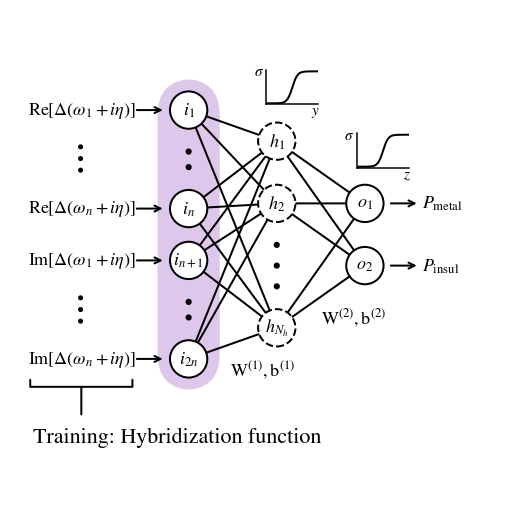

In [24]:
xsize, ysize=1.2, 1.8
ax0 = plt.axes((0.12, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)
ax5 = plt.axes((0.72, 1.46, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax6 = plt.axes((0.93, 1.24, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)


inode_x, inode_y = 0.35, 0.8
hnode_x, hnode_y = 0.52, inode_y-0.12/2
onode_x, onode_y = 0.69, inode_y-0.12*2+0.12/2

r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.22, edgecolor = 'none', facecolor = '#6600a7')
r2 = mpatches.FancyBboxPatch((hnode_x-0.04,hnode_y-0.12*3-0.04), 0.08,0.44, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.22, edgecolor = 'none', facecolor = '#6600a7')
r3 = mpatches.FancyBboxPatch((onode_x-0.04,onode_y-0.12-0.04), 0.08,0.2, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.22, edgecolor = 'none', facecolor = '#6600a7')
ax0.add_patch(r1)
#ax0.add_patch(r2)
#ax0.add_patch(r3)

# input layer
for i in range(1):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
    ax0.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.08-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    o = mpatches.Circle((inode_x, inode_y-0.37-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.19-0.10*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.annotate('', xy=(inode_x-0.1, inode_y-0.19-0.10*i), xytext=(inode_x-0.05, inode_y-0.19-0.10*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax0.text(inode_x, inode_y-0.19-0.10*0, r'$i_n$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
ax0.text(inode_x, inode_y-0.19-0.10*1, r'$i_{n+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.31, inode_y, r'Re$\left[\Delta(\omega_1+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.31, inode_y-0.19, r'Re$\left[\Delta(\omega_n+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.31, inode_y-0.19-0.10*1, r'Im$\left[\Delta(\omega_1+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(inode_x-0.31, inode_y-0.12*4, r'Im$\left[\Delta(\omega_n+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax0.transAxes)

o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
ax0.add_patch(o)
ax0.text(inode_x, inode_y-0.12*4, r'$i_{2n}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)

ax0.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
# hidden layer
for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
    ax0.add_patch(o)
    ax0.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
ax0.add_patch(o)
ax0.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
# output layer
for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax0.add_patch(o)
    ax0.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax0.transAxes)
    ax0.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax0.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax0.transAxes)
ax0.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax0.transAxes)
# lines
iy_coord = [inode_y]
iy_coord.append(inode_y-0.19)
iy_coord.append(inode_y-0.19-0.10*1)
iy_coord.append(inode_y-0.12*4)
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax0.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax0.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
        
ax0.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax0.transAxes)
ax0.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax0.transAxes)

ax0.text(0.05, inode_y-0.12*4-0.15, 'Training: Hybridization function', fontsize = 22, \
             va='center', transform = ax0.transAxes)
ax0.annotate('', xy=(inode_x-0.207, inode_y-0.12*4-0.05), xytext=(inode_x-0.207, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=3.65, lengthB=.5',lw=2), transform = ax0.transAxes)

ax0.text(inode_x-0.207, inode_y-0.19/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax0.transAxes)
ax0.text(inode_x-0.207, inode_y-0.77/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax0.transAxes)

ax5.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax5.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax5.set_xlabel(r'$y$', fontsize=15)
ax5.xaxis.set_label_coords(0.95, -0.03)
ax5.yaxis.set_label_coords(-0.15, 0.75)
ax5.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax5.set_ylim(-0.03,1.05)
ax5.set_xlim(-5,5)
ax6.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax6.set_xlabel(r'$z$', fontsize=15)
ax6.xaxis.set_label_coords(0.95, -0.03)
ax6.yaxis.set_label_coords(-0.15, 0.75)
ax6.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax6.set_ylim(-0.03,1.05)
ax6.set_xlim(-5,5)



plt.savefig('fig1_1.png', bbox_inches='tight')

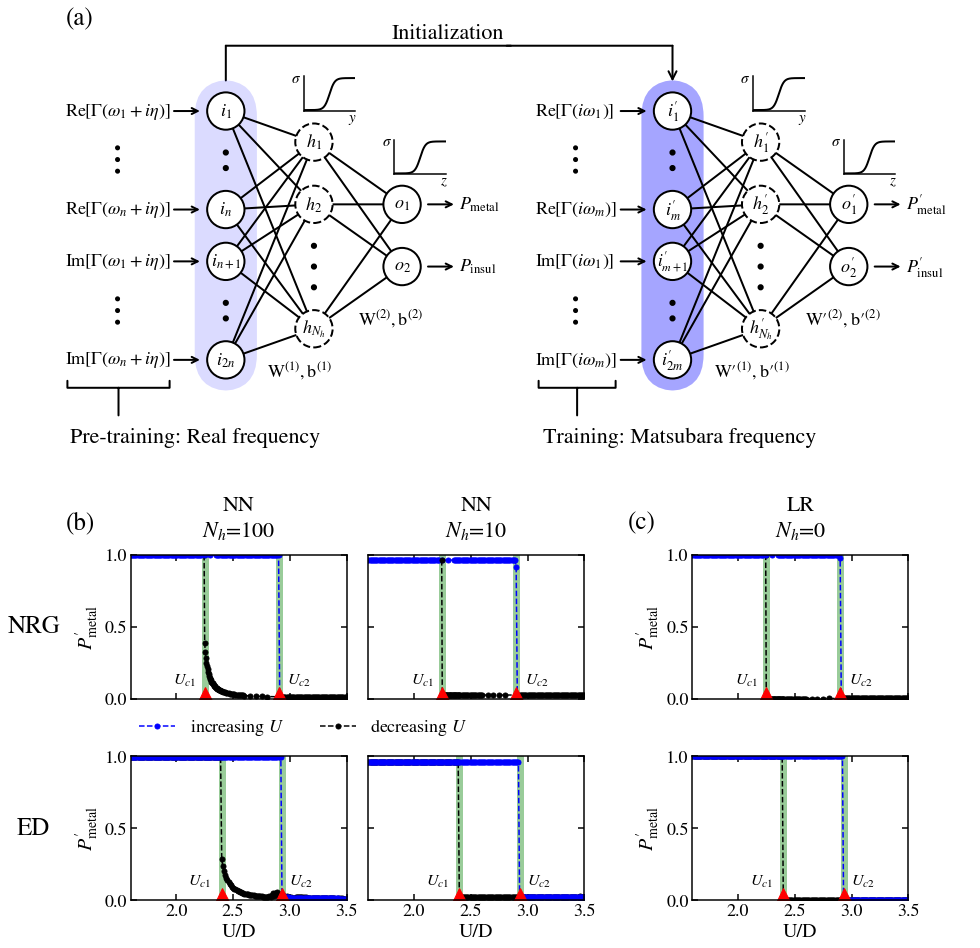

In [28]:
xsize, ysize=1.2, 1.8
ax1 = plt.axes((0.1, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)
plt.gcf().text(0.15,ysize-0.06, '(a)', fontsize = 25)


inode_x, inode_y = 0.35, 0.8
hnode_x, hnode_y = 0.52, inode_y-0.12/2
onode_x, onode_y = 0.69, inode_y-0.12*2+0.12/2

# (a)-1 ######################################################################
r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.14, edgecolor = 'none', facecolor = 'b')
ax1.add_patch(r1)

# input layer
for i in range(1):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
    ax1.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.08-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    o = mpatches.Circle((inode_x, inode_y-0.37-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.19-0.10*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.annotate('', xy=(inode_x-0.1, inode_y-0.19-0.10*i), xytext=(inode_x-0.05, inode_y-0.19-0.10*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax1.text(inode_x, inode_y-0.19-0.10*0, r'$i_n$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
ax1.text(inode_x, inode_y-0.19-0.10*1, r'$i_{n+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.31, inode_y, r'Re$\left[\Delta(\omega_1+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.31, inode_y-0.19, r'Re$\left[\Delta(\omega_n+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.31, inode_y-0.19-0.10*1, r'Im$\left[\Delta(\omega_1+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.31, inode_y-0.12*4, r'Im$\left[\Delta(\omega_n+i\eta)\right]$', fontsize = 18, \
             va='center', transform = ax1.transAxes)

o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
ax1.add_patch(o)
ax1.text(inode_x, inode_y-0.12*4, r'$i_{2n}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)

ax1.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
# hidden layer
for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
    ax1.add_patch(o)
    ax1.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
ax1.add_patch(o)
ax1.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
# output layer
for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
    ax1.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax1.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax1.transAxes)
ax1.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax1.transAxes)
# lines
iy_coord = [inode_y]
iy_coord.append(inode_y-0.19)
iy_coord.append(inode_y-0.19-0.10*1)
iy_coord.append(inode_y-0.12*4)
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax1.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax1.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
        
ax1.annotate('', xy=(inode_x, inode_y+0.126), xytext=(xsize-0.3, inode_y+0.126), xycoords='axes fraction',\
             arrowprops=dict(arrowstyle='-', color='k', shrinkA=0, shrinkB=0,lw=2), zorder=0)
ax1.annotate('', xy=(inode_x, inode_y+0.059), xytext=(inode_x, inode_y+0.126), xycoords='axes fraction',\
             arrowprops=dict(arrowstyle='-', color='k', shrinkA=0, shrinkB=0,lw=2), zorder=0)
ax1.text(inode_x+0.32, inode_y+0.15, 'Initialization', fontsize = 22, \
             va='center', transform = ax1.transAxes)

ax1.text(0.05, inode_y-0.12*4-0.15, 'Pre-training: Real frequency', fontsize = 22, \
             va='center', transform = ax1.transAxes)
ax1.annotate('', xy=(inode_x-0.207, inode_y-0.12*4-0.05), xytext=(inode_x-0.207, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=3.65, lengthB=.5',lw=2), transform = ax1.transAxes)
ax1.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax1.transAxes)
ax1.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax1.transAxes)


ax1.text(inode_x-0.207, inode_y-0.19/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax1.transAxes)
ax1.text(inode_x-0.207, inode_y-0.77/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax1.transAxes)

#(a)-2 ###########################################################
ax2 = plt.axes((xsize-0.15, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)
inode_x, inode_y = 0.42, 0.8
hnode_x, hnode_y = 0.59, inode_y-0.12/2
onode_x, onode_y = 0.76, inode_y-0.12*2+0.12/2

r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.35, edgecolor = 'none', facecolor = 'b')
ax2.add_patch(r1)

# input layer
for i in range(1):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax2.add_patch(o)
    ax2.text(inode_x, inode_y-0.12*i, fr'$i^\prime_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.08-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax2.add_patch(o)
    o = mpatches.Circle((inode_x, inode_y-0.37-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax2.add_patch(o)
    
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.19-0.10*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax2.add_patch(o)
    ax2.annotate('', xy=(inode_x-0.1, inode_y-0.19-0.10*i), xytext=(inode_x-0.05, inode_y-0.19-0.10*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax2.text(inode_x, inode_y-0.19-0.10*0, r'$i^\prime_m$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
ax2.text(inode_x, inode_y-0.19-0.10*1, r'$i^\prime_{m+1}$', fontsize = 17, \
             ha='center', va='center', transform = ax2.transAxes)

ax2.text(inode_x-0.265, inode_y, r'Re$\left[\Delta(i\omega_1)\right]$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(inode_x-0.265, inode_y-0.19, r'Re$\left[\Delta(i\omega_m)\right]$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(inode_x-0.265, inode_y-0.19-0.10*1, r'Im$\left[\Delta(i\omega_1)\right]$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(inode_x-0.265, inode_y-0.12*4, r'Im$\left[\Delta(i\omega_m)\right]$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
ax2.add_patch(o)
ax2.text(inode_x, inode_y-0.12*4, r'$i^\prime_{2m}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)

ax2.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})

for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='--', zorder = 2)
    ax2.add_patch(o)
    ax2.text(hnode_x, hnode_y-0.12*i, fr'$h^\prime_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='--', zorder = 2)
ax2.add_patch(o)
ax2.text(hnode_x, hnode_y-0.12*3, r'$h^\prime_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)

for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
    ax2.text(onode_x, onode_y-0.12*i, fr'$o^\prime_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax2.text(onode_x+0.11, onode_y, r'$P^\prime_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)
ax2.text(onode_x+0.11, onode_y-0.12, r'$P^\prime_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)

iy_coord = [inode_y]
iy_coord.append(inode_y-0.19)
iy_coord.append(inode_y-0.19-0.10*1)
iy_coord.append(inode_y-0.12*4)
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax2.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax2.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
        
ax2.annotate('', xy=(inode_x, inode_y+0.057), xytext=(inode_x, inode_y+0.126), xycoords='axes fraction',\
             arrowprops=dict(arrowstyle='->', color='k', shrinkA=0, shrinkB=0, lw=2,mutation_scale=20), zorder=0)
ax2.annotate('', xy=(inode_x, inode_y+0.126), xytext=(0.1, inode_y+0.126), xycoords='axes fraction',\
             arrowprops=dict(arrowstyle='-', color='k', shrinkA=0, shrinkB=0,lw=2,), zorder=0)
ax2.text(inode_x-0.25, inode_y-0.12*4-0.15, 'Training: Matsubara frequency', fontsize = 22, \
             va='center', transform = ax2.transAxes)
ax2.annotate('', xy=(inode_x-0.184, inode_y-0.12*4-0.05), xytext=(inode_x-0.184, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=2.75, lengthB=.5', lw=2), transform = ax2.transAxes)
ax2.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}\prime^{(1)}, \mathrm{b}\prime^{(1)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}\prime^{(2)}, \mathrm{b}\prime^{(2)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)

ax2.text(inode_x-0.185, inode_y-0.19/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax2.transAxes)
ax2.text(inode_x-0.185, inode_y-0.77/2, r'$\cdots$', fontsize=40, rotation=90, \
         va='center', ha='center', transform=ax2.transAxes)

ax5 = plt.axes((0.7, 1.44, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax6 = plt.axes((0.91, 1.22, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax5.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax5.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax5.set_xlabel(r'$y$', fontsize=15)
ax5.xaxis.set_label_coords(0.95, -0.03)
ax5.yaxis.set_label_coords(-0.15, 0.75)
ax5.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax5.set_ylim(-0.03,1.05)
ax5.set_xlim(-5,5)
ax6.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax6.set_xlabel(r'$z$', fontsize=15)
ax6.xaxis.set_label_coords(0.95, -0.03)
ax6.yaxis.set_label_coords(-0.15, 0.75)
ax6.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax6.set_ylim(-0.03,1.05)
ax6.set_xlim(-5,5)

ax7 = plt.axes((1.74, 1.44, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax8 = plt.axes((1.95, 1.22, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax7.spines['top'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax7.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax7.set_xlabel(r'$y$', fontsize=15)
ax7.xaxis.set_label_coords(0.95, -0.03)
ax7.yaxis.set_label_coords(-0.15, 0.75)
ax7.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax7.set_ylim(-0.03,1.05)
ax7.set_xlim(-5,5)
ax8.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax8.set_xlabel(r'$z$', fontsize=15)
ax8.xaxis.set_label_coords(0.95, -0.03)
ax8.yaxis.set_label_coords(-0.15, 0.75)
ax8.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax8.set_ylim(-0.03,1.05)
ax8.set_xlim(-5,5)

# (b) #################################################################
a, b = -0.2, 0
plt.gcf().text(0.15,-0.01, '(b)', fontsize = 25)
plt.gcf().text(1.45,-0.01, '(c)', fontsize = 25)
ax30 = plt.axes((0.5+a, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax31 = plt.axes((1.05+a, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax32 = plt.axes((1.6+b, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax40 = plt.axes((0.5+a, -1.3, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax41 = plt.axes((1.05+a, -1.3, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax42 = plt.axes((1.6+b, -1.3, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)


ax30.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax30.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax30.plot(U2_4, NN100model.forward(x_test_iw_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax30.plot(U1_4, NN100model.forward(x_test_iw_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax30.annotate(r'$U_{c1}$', xy=(0.25, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.annotate(r'$U_{c2}$', xy=(0.78, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax30.set_ylim(0,1)
ax30.set_xlim(1.6,3.5)

ax31.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax31.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax31.plot(U1_4, NN10model.forward(x_test_iw_up).data[:,0], 'bo--', ms=5, label = r'decreasing $U$')
ax31.plot(U2_4, NN10model.forward(x_test_iw_dn).data[:,0], 'ko--', ms=5, label = r'increasing $U$')
ax31.annotate(r'$U_{c1}$', xy=(0.25, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.annotate(r'$U_{c2}$', xy=(0.78, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax31.set_ylim(0,1)
ax31.set_xlim(1.6,3.5)

ax32.axvline(U_c1_4, c = '#99CC99', lw = '7'), ax32.axvline(U_c2_4, c = '#99CC99', lw = '7')
ax32.plot(U2_4, LRmodel.forward(x_test_iw_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax32.plot(U1_4, LRmodel.forward(x_test_iw_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax32.annotate(r'$U_{c1}$', xy=(0.25, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.annotate(r'$U_{c2}$', xy=(0.78, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.plot(np.array([U_c1_4, U_c2_4]), np.zeros(2), 'r^', ms=25)
ax32.set_ylim(0,1)
ax32.set_xlim(1.6,3.5)

ax40.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax40.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax40.plot(U2_ed, NN100model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax40.plot(U1_ed, NN100model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax40.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax40.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax40.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax40.set_ylim(0,1)
ax40.set_xlim(1.6,3.5)

ax41.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax41.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax41.plot(U2_ed, NN10model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax41.plot(U1_ed, NN10model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax41.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax41.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax41.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax41.set_ylim(0,1)
ax41.set_xlim(1.6,3.5)

ax42.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax42.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax42.plot(U2_ed, LRmodel.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax42.plot(U1_ed, LRmodel.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax42.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax42.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax42.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax42.set_ylim(0,1)
ax42.set_xlim(1.6,3.5)


ax30.set_xticks([2.0, 2.5, 3.0, 3.5])
ax31.set_xticks([2.0, 2.5, 3.0, 3.5])
ax32.set_xticks([2.0, 2.5, 3.0, 3.5])
ax40.set_xticks([2.0, 2.5, 3.0, 3.5])
ax41.set_xticks([2.0, 2.5, 3.0, 3.5])
ax42.set_xticks([2.0, 2.5, 3.0, 3.5])
ax30.set_xticklabels([])
ax31.set_xticklabels([])
ax32.set_xticklabels([])

ax30.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticks([0.0, 0.5, 1.0])
ax32.set_yticks([0.0, 0.5, 1.0])
ax40.set_yticks([0.0, 0.5, 1.0])
ax41.set_yticks([0.0, 0.5, 1.0])
ax42.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticklabels([])
ax41.set_yticklabels([])

ax30.tick_params(labelsize=18)
ax31.tick_params(labelsize=18)
ax32.tick_params(labelsize=18)
ax40.tick_params(labelsize=18)
ax41.tick_params(labelsize=18)
ax42.tick_params(labelsize=18)

ax30.set_ylabel(r'$P^\prime_{\mathrm{metal}}$', fontsize=20)
ax40.set_ylabel(r'$P^\prime_{\mathrm{metal}}$', fontsize=20)
ax32.set_ylabel(r'$P^\prime_{\mathrm{metal}}$', fontsize=20)
ax42.set_ylabel(r'$P^\prime_{\mathrm{metal}}$', fontsize=20)
ax40.set_xlabel('U/D', fontsize=20)
ax41.set_xlabel('U/D', fontsize=20)
ax42.set_xlabel('U/D', fontsize=20)

ax30.text(-0.45, 0.5, 'NRG', fontsize = 25, \
          ha='center',va='center', transform = ax30.transAxes)
ax40.text(-0.45, 0.5, 'ED', fontsize = 25, \
          ha='center',va='center', transform = ax40.transAxes)
ax30.text(0.5, 1.25, 'NN\n'+r'$N_h$=100', fontsize = 22, \
          ha='center',va='center', transform = ax30.transAxes)
ax31.text(0.5, 1.25, 'NN\n'+r'$N_h$=10', fontsize = 22, \
          ha='center',va='center', transform = ax31.transAxes)
ax32.text(0.5, 1.25, 'LR\n'+r'$N_h$=0', fontsize = 22, \
          ha='center',va='center', transform = ax32.transAxes)
handles,labels = ax30.get_legend_handles_labels()
ax30.legend([handles[1], handles[0]], [labels[1], labels[0]],ncol=2, bbox_to_anchor=(0.8, -0.2), loc='center', fontsize=18)




plt.savefig('fig2.pdf', bbox_inches='tight')

# Figure 3. Matrix representation & heatmap

In [ ]:
a = 0.05
ax00 = plt.axes([0.2+a, 1.4, 0.4, 0.6])
ax10 = plt.axes([0.2+a, 0.7, 0.4, 0.6])
ax20 = plt.axes([0.2+a, 0.0, 0.4, 0.6])
ax01 = plt.axes([1.0+a, 1.4, 0.6, 0.6])
ax11 = plt.axes([1.0+a, 0.7, 0.6, 0.6])
ax21 = plt.axes([1.0+a, 0.0, 0.6, 0.6])



im00 = ax00.imshow(W1_NN100, aspect=2638/100, cmap='bwr', **{'vmin':-0.02, 'vmax':0.02})
im10 = ax10.imshow(W1_NN10, aspect=2638/10, cmap='bwr', **{'vmin':-0.10, 'vmax':0.10})
im20 = ax20.imshow(W1_LR, aspect=2638/2, cmap='bwr', **{'vmin':-0.15, 'vmax':0.15})
ax00.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax10.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax20.yaxis.set_major_locator(ticker.MultipleLocator(1))
cax0=inset_axes(ax00, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax00.transAxes, borderpad=0)
cax1=inset_axes(ax10, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax10.transAxes, borderpad=0)
cax2=inset_axes(ax20, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax20.transAxes, borderpad=0)
cd = plt.colorbar(im00, cax=cax0)
cd = plt.colorbar(im10, cax=cax1)
cd = plt.colorbar(im20, cax=cax2)
ax00.annotate('', xy=(0.005, 1.1), xytext=(0.995, 1.1), xycoords='axes fraction',\
                 ha='center', va="center", \
                 arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0, 'lw':2})
ax00.annotate(r'Im$\Delta(\omega_n+i\eta)$', xy=(0.5, 1.15), xycoords = 'axes fraction', fontsize=20, ha='center')
ax00.set_ylabel('hidden node', fontsize=22)
ax10.set_ylabel('hidden node', fontsize=22)
ax20.set_ylabel('output node', fontsize=22)
ax20.set_xlabel('input node', fontsize=22)

ax01.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax11.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax21.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax01.plot(weq, (number*reW1_NN100)[20], lw=2, c='b')
ax11.plot(weq, (number*reW1_NN10)[1], lw=2, c='b')
ax21.plot(weq, (number*reW1_LR)[0], lw=2, c='b')
ax01.set_xlim(-5,5), ax11.set_xlim(-5,5), ax21.set_xlim(-5,5)
ax01.set_ylim(-0.5,12), ax11.set_ylim(-0.5,12), ax21.set_ylim(-0.5,12)
ax01.set_xticks([-5, -2.5, 0, 2.5, 5])
ax11.set_xticks([-5, -2.5, 0, 2.5, 5])
ax21.set_xticks([-5, -2.5, 0, 2.5, 5])
ax10.set_xticklabels([]), ax00.set_xticklabels([]), ax11.set_xticklabels([]), ax01.set_xticklabels([])

ax21.set_xlabel(r'$\omega$', fontsize=22)
ax01.set_ylabel(r'$\mathrm{W}^{(1)}_{j}(\omega)$', rotation=0, labelpad=32, va='center', fontsize=21)
ax11.set_ylabel(r'$\mathrm{W}^{(1)}_{j}(\omega)$', rotation=0, labelpad=32, va='center', fontsize=21)
ax21.set_ylabel(r'$\mathrm{W}^{(1)}_{j}(\omega)$', rotation=0, labelpad=32, va='center', fontsize=21)
#ax21.set_xticklabels([])


'''
ax02 = plt.axes([1.39+a, 1.4+0.36, 0.19, 0.2])
ax12 = plt.axes([1.39+a, 0.7+0.36, 0.19, 0.2])
ax22 = plt.axes([1.39+a, 0.0+0.36, 0.19, 0.2])
ax02.plot(weq[::1], (number*reW1_NN100)[20][::1], lw=1.5, c='b')
ax12.plot(weq[::1], (number*reW1_NN10)[1][::1], lw=1.5, c='b')
ax22.plot(weq[::1], (number*reW1_LR)[0][::1], lw=1.5, c='b')
ax02.axvspan(-0.3, +0.3, alpha=0.5, color='#ffee52')
ax12.axvspan(-0.3, +0.3, alpha=0.5, color='#ffee52')
ax22.axvspan(-0.3, +0.3, alpha=0.5, color='#ffee52')
ax02.set_xlim(-0.5,3), ax12.set_xlim(-0.5,3), ax22.set_xlim(-0.5,3)
ax02.set_ylim(-0.2,0.5), ax12.set_ylim(-0.2,0.5), ax22.set_ylim(-0.2,0.5)
ax02.tick_params(labelsize=14), ax12.tick_params(labelsize=14), ax22.tick_params(labelsize=14)
'''
plt.gcf().text(0.05, 2.0-0.05, '(a)', fontsize = 25)
plt.gcf().text(0.05, 1.3-0.05, '(b)', fontsize = 25)
plt.gcf().text(0.05, 0.6-0.05, '(c)', fontsize = 25)
ax01.annotate('', xy=(1.15,-2.1), xytext=(1.15,0.7), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
plt.gcf().text(3.82, 0.5, r'$N_h=100$', fontsize = 22, \
          ha='left',va='center', transform = ax00.transAxes)
plt.gcf().text(3.82, 0.5, r'$N_h=10$', fontsize = 22, \
          ha='left',va='center', transform = ax10.transAxes)
plt.gcf().text(3.82, 0.5, r'$N_h=0$', fontsize = 22, \
          ha='left',va='center', transform = ax20.transAxes)
plt.savefig('fig3.pdf')

In [ ]:
order = ['a', 'b', 'c']
#fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j] = plt.axes([j*0.8, 3.2-i*1.6, 0.5, 0.5*1.5])
        plt.gcf().text(j*0.8, 3.2-i*1.6+0.8, f'{(i+1)}-({order[j]})', fontsize = 25)

        
# FIRST ROW
im00 = ax[0,0].imshow(W1_NN100, aspect=2638/100, cmap='bwr', **{'vmin':-0.02, 'vmax':0.02})
im10 = ax[0,1].imshow(W1_NN10, aspect=2638/10, cmap='bwr', **{'vmin':-0.10, 'vmax':0.10})
im20 = ax[0,2].imshow(W1_LR, aspect=2638/2, cmap='bwr', **{'vmin':-0.15, 'vmax':0.15})
ax[0,0].yaxis.set_major_locator(ticker.MultipleLocator(25))
ax[0,2].yaxis.set_major_locator(ticker.MultipleLocator(2))
ax[0,2].yaxis.set_major_locator(ticker.MultipleLocator(1))
cax0=inset_axes(ax[0,0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[0,0].transAxes, borderpad=0)
cax1=inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
cax2=inset_axes(ax[0,2], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[0,2].transAxes, borderpad=0)
cd = plt.colorbar(im00, cax=cax0)
cd = plt.colorbar(im10, cax=cax1)
cd = plt.colorbar(im20, cax=cax2)
ax[0,0].annotate('', xy=(0, -0.15), xytext=(1, -0.15), xycoords='axes fraction',\
                 ha='center', va="center", \
                 arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0, 'lw':2})
ax[0,0].annotate(r'Im$\Delta(\omega_n+i\eta)$', xy=(0.5, -0.25), xycoords = 'axes fraction', fontsize=20, ha='center')
ax[0,0].set_ylabel('node', fontsize=20)


# SECOND ROW
im02 = ax[1,0].imshow(number*reW1_NN100, aspect=2000/100, cmap='bwr', **{'vmin':-0.80, 'vmax':0.80})
im12 = ax[1,1].imshow(number*reW1_NN10, aspect=2000/10, cmap='bwr', **{'vmin':-1.60, 'vmax':1.60})
im22 = ax[1,2].imshow(number*reW1_LR, aspect=2000/2, cmap='bwr', **{'vmin':-2.40, 'vmax':2.40})
ax[1,0].yaxis.set_major_locator(ticker.MultipleLocator(25))
ax[1,1].yaxis.set_major_locator(ticker.MultipleLocator(2))
ax[1,2].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1,0].xaxis.set_major_locator(ticker.MultipleLocator(500))
ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(500))
ax[1,2].xaxis.set_major_locator(ticker.MultipleLocator(500))
ax[1,0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
ax[1,1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
ax[1,2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
cax0=inset_axes(ax[1,0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[1,0].transAxes, borderpad=0)
cax1=inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cax2=inset_axes(ax[1,2], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[1,2].transAxes, borderpad=0)
cd = plt.colorbar(im02, cax=cax0)
cd = plt.colorbar(im12, cax=cax1)
cd = plt.colorbar(im22, cax=cax2)
ax[1,0].set_xlabel(r'$\omega$', fontsize=20)
ax[1,1].set_xlabel(r'$\omega$', fontsize=20)
ax[1,2].set_xlabel(r'$\omega$', fontsize=20)
ax[1,0].set_ylabel('node', fontsize=20)
ax[1,0].annotate('', xy=(0, -0.225), xytext=(1, -0.225), xycoords='axes fraction',\
                 ha='center', va="center", \
                 arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0, 'lw':2})
ax[1,0].annotate(r'Im$\Delta(\omega+i\eta)$', xy=(0.5, -0.325), xycoords = 'axes fraction', fontsize=20, ha='center')

# THIRD ROW
iwwidth=1250
im04 = ax[2,0].imshow(iwW1_NN100[:,:iwwidth], aspect=iwwidth/100, cmap='bwr', **{'vmin':-0.80, 'vmax':0.80})
im14 = ax[2,1].imshow(iwW1_NN10[:,:iwwidth], aspect=iwwidth/10, cmap='bwr', **{'vmin':-1.50, 'vmax':1.50})
im24 = ax[2,2].imshow(iwW1_LR[:,:iwwidth], aspect=iwwidth/2, cmap='bwr', **{'vmin':-2.00, 'vmax':2.00})
ax[2,0].yaxis.set_major_locator(ticker.MultipleLocator(25))
ax[2,1].yaxis.set_major_locator(ticker.MultipleLocator(2))
ax[2,2].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[2,0].xaxis.set_major_locator(ticker.MultipleLocator(400))
ax[2,1].xaxis.set_major_locator(ticker.MultipleLocator(400))
ax[2,2].xaxis.set_major_locator(ticker.MultipleLocator(400))
ax[2,0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1e'%(omega[int(x)])))
ax[2,1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1e'%(omega[int(x)])))
ax[2,2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1e'%(omega[int(x)])))
cax0=inset_axes(ax[2,0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[2,0].transAxes, borderpad=0)
cax1=inset_axes(ax[2,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[2,1].transAxes, borderpad=0)
cax2=inset_axes(ax[2,2], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.1, 0., 1, 1), bbox_transform=ax[2,2].transAxes, borderpad=0)
cd = plt.colorbar(im04, cax=cax0)
cd = plt.colorbar(im14, cax=cax1)
cd = plt.colorbar(im24, cax=cax2)
ax[2,0].set_ylabel('node', fontsize=20)
ax[2,0].set_xlabel(r'$i\omega_n$', fontsize=20)
ax[2,1].set_xlabel(r'$i\omega_n$', fontsize=20)
ax[2,2].set_xlabel(r'$i\omega_n$', fontsize=20)
ax[2,0].annotate('', xy=(0, -0.225), xytext=(1, -0.225), xycoords='axes fraction',\
                 ha='center', va="center", \
                 arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0, 'lw':2})
ax[2,0].annotate(r'Im$\Delta(i\omega_n)$', xy=(0.5, -0.325), xycoords = 'axes fraction', fontsize=20, ha='center')
    
    
ax1 = plt.axes([1.25,2.65,0.35,0.35])
ax[0,1].annotate('Rescale input', xy=(-0.15,-0.55), xycoords = 'axes fraction', fontsize=30, \
                 ha='center', va='center')
ax[0,1].annotate('', xy=(0.5,-0.9), xytext=(0.5,-0.2), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':40, 'fc':'None', 'ec':'k'})
ax1.hist(w.real, bins=51, color='#d2386c')
ax1.set_xlabel(r'real frequency $\omega$', fontsize=20)
ax1.set_yticklabels(['0', r'$10^1$'])
ax1.set_ylabel('count', color='#d2386c', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#d2386c')
ax1.set_xlim(-5,5)
ax2 = ax1.twinx()
ax2.plot(w.real, np.arange(len(w)), lw=3, c='#2166b0')
ax2.set_ylabel('cumulant count', color='#2166b0', fontsize=20)
ax2.tick_params(axis='y', labelcolor='#2166b0')
ax2.set_yticklabels(['0', r'$10^1$', r'$2\cdot10^1$'])
ax2.set_ylim(0, 2638)

ax3 = plt.axes([1.25, 1.05, 0.35, 0.35])
ax[1,1].annotate('Convert to \n Matsubara frequency', xy=(-0.15, -0.55), xycoords = 'axes fraction', fontsize=30, ha='center', va='center')
ax[1,1].annotate('', xy=(0.5,-0.9), xytext=(0.5,-0.2), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':40, 'fc':'None', 'ec':'k'})
ax3.plot(omega, iwnumber, lw=3, c='#0a763f')
ax3.set_xlabel(r'imag frequency $i\omega_n$', fontsize=20)
ax3.set_ylabel('count', fontsize=20)
ax3.set_yscale('log')

plt.savefig('weightmap.png')

# Quasiparticle weight

In [10]:
beta = 10000
U_c1_4, U_c2_4 = 2.25, 2.88
    
w_len = len(np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

up_num = 229
dn_num = 242

U = np.array([0.001*i for i in range(600, 5001)])
U1_4 = np.zeros(up_num, dtype = 'float64')
U2_4 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_4[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_4[n] = u
    n += 1
    

self_up = np.zeros((len(U1_4), 2638), dtype = 'float64')
self_dn = np.zeros((len(U2_4), 2638), dtype = 'float64')


for i, u in enumerate(U1_4):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    self_up[i] = S_r
for i, u in enumerate(U2_4):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    self_dn[i] = S_r

Z1 = np.zeros(len(U1_4), dtype='float64')
for i, u in enumerate(U1_4):
    a = 0.5*(self_up[i, 1320]-self_up[i, 1319]+self_up[i, 1318]-self_up[i, 1317])/(w.real[1320]-w.real[1317])
    Z1[i] = 1/(1-a)
    
Z2 = np.zeros(len(U2_4), dtype='float64')
for i, u in enumerate(U1_4):
    b = 0.5*(self_dn[i, 1320]-self_dn[i, 1319]+self_dn[i, 1318]-self_dn[i, 1317])/(w.real[1320]-w.real[1317])
    Z2[i] = 1/(1-b)

(1.6, 3.5)

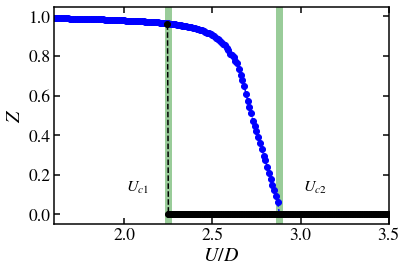

In [11]:
plt.axvline(U_c1_4, c = '#99CC99', lw = '7')
plt.axvline(U_c2_4, c = '#99CC99', lw = '7')
plt.plot(U1_4, Z1, 'bo--')
plt.plot(U2_4, Z2, 'ko--')
plt.annotate(r'$U_{c1}$', xy=(0.25, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.78, 0.15), xycoords = 'axes fraction', fontsize=16, ha='center')
plt.xlabel(r'$U/D$', fontsize=20)
plt.ylabel(r'$Z$', fontsize=20)
plt.xlim(1.6, 3.5)